In [1]:
from collections import defaultdict, Counter

from workflow.config import PCT_VALUES
from workflow.fastani.remove_gunc_failed_contigs_by_contamination_sp_cluster import RemoveGuncFailedContigsByContaminationSpCluster
from workflow.gunc.aggregate_max_css_level_merged import AggregateMaxCssLevelMerged
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from workflow.external.gtdb_metadata import GtdbMetadataR207

In [2]:
DF_META = GtdbMetadataR207().output().read_cached()
DF_META.head()

,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,contig_count,...,gtdb_type_species_of_genus,ncbi_taxonomy,ncbi_taxonomy_unfiltered,domain,phylum,class,order,family,genus,species
gid,,,,,,,,,,,,,,,,,,,,,
GCA_000006155.2,1916,93.12,0.0,1171,g__Bacillus (UID902),324,0.0,4305660,80.178992,426,...,f,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,d__Bacteria;x__Terrabacteria group;p__Firmicut...,d__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae_G,g__Bacillus_A,s__Bacillus_A anthracis
GCA_000007325.1,1,99.95,0.0,149,k__Bacteria (UID2329),89,0.0,1973459,90.754610,1,...,t,d__Bacteria;p__Fusobacteria;c__Fusobacteriia;o...,d__Bacteria;p__Fusobacteria;c__Fusobacteriia;o...,d__Bacteria,p__Fusobacteriota,c__Fusobacteriia,o__Fusobacteriales,f__Fusobacteriaceae,g__Fusobacterium,s__Fusobacterium nucleatum
GCA_000007385.1,0,99.82,0.0,481,c__Gammaproteobacteria (UID4202),276,0.0,4190634,84.805944,1,...,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Xanthomonadales,f__Xanthomonadaceae,g__Xanthomonas,s__Xanthomonas oryzae
GCA_000008085.1,0,73.13,0.0,149,k__Archaea (UID2),107,0.0,462902,94.299480,1,...,t,d__Archaea;p__Nanoarchaeota;c__;o__Nanoarchaea...,d__Archaea;x__DPANN group;p__Nanoarchaeota;o__...,d__Archaea,p__Nanoarchaeota,c__Nanoarchaeia,o__Nanoarchaeales,f__Nanoarchaeaceae,g__Nanoarchaeum,s__Nanoarchaeum equitans
GCA_000008885.1,0,100.00,0.0,134,k__Bacteria (UID2495),80,0.0,617456,87.831079,2,...,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales_A,f__Enterobacteriaceae_A,g__Wigglesworthia,s__Wigglesworthia glossinidia_A


In [3]:
DF = RemoveGuncFailedContigsByContaminationSpCluster().output().read_cached()
print(DF.shape)

UNQ_GIDS = set(DF.index.get_level_values(0))

print(f'{len(UNQ_GIDS):,} failed gids')
DF.head()

(578539, 5)
35,723 failed gids


new_sp_rep      ani        af    type  same
gid             pct                                                  
GCA_000143435.1 1    GCF_001435955.1  97.3270  0.875591  sp_rep  True
                5    GCF_001435955.1  97.3270  0.875591  sp_rep  True
                15   GCF_001435955.1  97.6349  0.829228  sp_rep  True
GCA_000153745.1 5                NaN      NaN       NaN  no_ani  True
GCA_000155005.1 1    GCF_003697165.2  96.5203  0.827668  sp_rep  True

In [19]:
from tqdm import tqdm
from workflow.util.paths import get_gid_root

import os
def gen_data():

    # Some were originally run with more pct values, but just reduce to the analysis set
    df_changed = DF[DF['same'] == False]
    df_changed = df_changed.reset_index()
    df_changed = df_changed[df_changed['pct'].isin(PCT_VALUES)]

    gids = frozenset(df_changed['gid'].unique())
    print(len(gids))

    dfs = list()
    for gid in tqdm(gids):
        gid_root = get_gid_root(gid)
        path_fastani = os.path.join(gid_root, 'fastani_gunc_failed_pct_0.h5')
        df_ani = pd.read_hdf(path_fastani)

        df_ani['query'] = gid

        dfs.append(df_ani)


    return pd.concat(dfs, ignore_index=True)



data = gen_data()

print(data)

226


100%|██████████| 226/226 [00:06<00:00, 32.76it/s]


             reference  pct      ani        af            query
0      GCF_000011205.1    0   0.0000  0.000000  GCA_003086435.1
1      GCF_008326425.1    0   0.0000  0.000000  GCA_003086435.1
2      GCA_015520735.1    0   0.0000  0.000000  GCA_003086435.1
3      GCA_003661865.1    0   0.0000  0.000000  GCA_003086435.1
4      GCA_011056395.1    0   0.0000  0.000000  GCA_003086435.1
...                ...  ...      ...       ...              ...
22595  GCA_905208345.1    0  93.4343  0.860627  GCA_902363945.1
22596  GCA_900556705.1    0  93.0878  0.900641  GCA_902363945.1
22597  GCA_900551605.1    0  92.8773  0.901914  GCA_902363945.1
22598  GCA_905214525.1    0  95.0988  0.827027  GCA_902363945.1
22599  GCA_900544875.1    0  94.6284  0.879056  GCA_902363945.1

[22600 rows x 5 columns]


226
GCA_900557355.1<<<<<<<<<
GCA_012964215.1<<<<<<<<<
GCA_016777745.1<<<<<<<<<
GCA_002725495.1<<<<<<<<<
GCA_003519645.1<<<<<<<<<
GCA_018433265.1<<<<<<<<<
GCA_003520315.1<<<<<<<<<
GCA_002712565.1<<<<<<<<<
4254
2308
6562


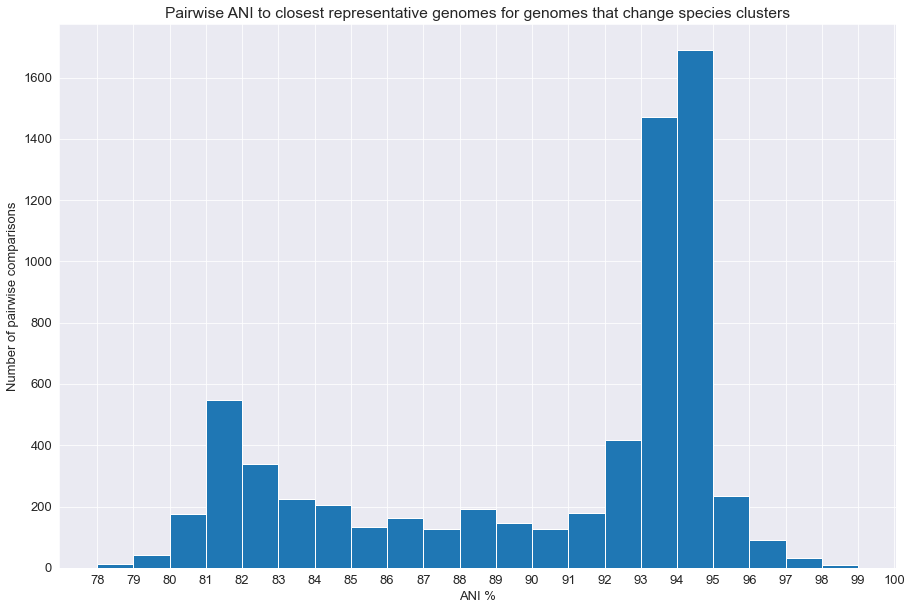

In [68]:
def asd():

    gids = set(data['query'].unique())

    print(len(gids))

    data_af = data[data['af'] >= 0.5]

    all_ani_values = list()
    for gid in gids:
        gid_is_rep = DF_META.loc[gid, 'gtdb_representative'] == 't'
        df_subset = data_af[data_af['query'] == gid]

        if gid_is_rep:
            df_subset = df_subset[df_subset['reference'] != gid]

        if len(df_subset) == 0:
            print(gid + '<<<<<<<<<')
        else:
            all_ani_values.extend(df_subset['ani'])

    fig, ax = plt.subplots(figsize=(15, 10))
    plt.rcParams.update({'font.size': 13})
    plt.rcParams['svg.fonttype'] = 'none'
    ax.hist(all_ani_values, bins=list(range(78, 100)))
    plt.xticks(list(range(78, 101)))

    plt.title('Pairwise ANI to closest representative genomes for genomes that change species clusters')
    plt.ylabel('Number of pairwise comparisons')
    plt.xlabel('ANI %')

    plt.savefig('/tmp/delta_ani_to_reps.svg')



    n_above_92 = sum([x >= 90 for x in all_ani_values])
    n_below_92 = sum([x < 90 for x in all_ani_values])

    print(n_above_92)
    print(n_below_92)
    print(n_above_92 + n_below_92)



    return

asd()

226
GCA_900557355.1<<<<<<<<<
GCA_012964215.1<<<<<<<<<
GCA_016777745.1<<<<<<<<<
GCA_002725495.1<<<<<<<<<
GCA_003519645.1<<<<<<<<<
GCA_018433265.1<<<<<<<<<
GCA_003520315.1<<<<<<<<<
GCA_002712565.1<<<<<<<<<


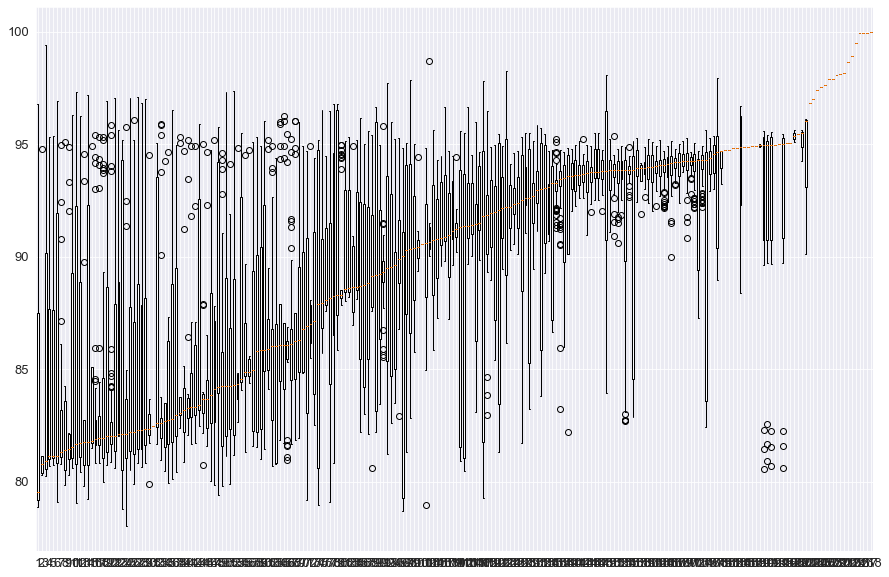

In [66]:
import numpy as np
def as_boxplot():

    gids = set(data['query'].unique())

    print(len(gids))

    data_af = data[data['af'] >= 0.5]

    d_gid_to_ani_values = dict()
    for gid in gids:
        gid_is_rep = DF_META.loc[gid, 'gtdb_representative'] == 't'
        df_subset = data_af[data_af['query'] == gid]

        if gid_is_rep:
            df_subset = df_subset[df_subset['reference'] != gid]

        if len(df_subset) == 0:
            print(gid + '<<<<<<<<<')
        else:
            d_gid_to_ani_values[gid] = [float(x) for x in df_subset['ani']]

    fig, ax = plt.subplots(figsize=(15, 10))
    plt.rcParams.update({'font.size': 13})
    plt.rcParams['svg.fonttype'] = 'none'

    values = sorted(list(d_gid_to_ani_values.values()), key=lambda x: np.median(x))
    plt.boxplot(values)


    return


    ax.hist(all_ani_values, bins=list(range(78, 100)))
    plt.xticks(list(range(78, 101)))

    plt.title('Pairwise ANI to closest representative genomes for genomes that change species clusters')
    plt.ylabel('Number of pairwise comparisons')
    plt.xlabel('ANI %')




    return

as_boxplot()